# ML model for October
Splitting based on spatial distribution

## Import libraries

In [49]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import plotly
from scipy.stats import gaussian_kde
import geopandas as gpd
from shapely.geometry import Point
from scipy.special import inv_boxcox


## Load the data

In [50]:
# import the previously saved stations data to the notebook

final_df_oct_new = None
with open("final_df_oct_new", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    final_df_oct_new = pickle.load(file)

# Load the shapefile for Bavaria
shapefile_path = r"H:\study_project\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

In [51]:
with open("lambda_boxcox", 'rb') as file:
    lambda_boxcox = pickle.load(file)

In [52]:
final_df_oct_new

,NO3-N [mg/l],NO3-N [mg/l] BC,station_name,station_number,water_body,lat,lon,slope_avg,elev_avg,lc_avg_01,...,soil_avg_04,soil_avg_05,soil_avg_06,soil_avg_07,soil_avg_08,soil_avg_09,soil_avg_10,tmin_avg_10,tmax_avg_10,prec_sum_10
0,4.670667,2.119408,"Strbr. in Höhe v. Stein, obh. KA",13516,Ölschnitz,50.062500,11.704167,216.0,584.0,15.0,...,36.0,16.0,15.0,18.0,1236.0,240.0,3.0,37.0,119.0,7829.0
1,2.983333,1.338301,Str.br.von Neundorf nach Bächlein,15123,Föritz,50.254167,11.212500,240.0,381.0,22.0,...,36.0,12.0,14.0,19.0,1287.0,240.0,4.0,42.0,131.0,1762.0
2,6.215000,2.665257,Strbr. Höhe Äußerer Bürgergraben,20496,Schwabbach,49.987500,9.979167,118.0,303.0,0.0,...,43.0,23.0,8.0,24.0,1282.0,236.0,8.0,49.0,137.0,5845.0
3,2.254250,0.931808,Strbr. Oberteich,23397,Seibertsbach,49.937500,12.212500,190.0,589.0,23.0,...,38.0,15.0,17.0,23.0,1215.0,240.0,6.0,38.0,121.0,2833.0
4,6.177333,2.672360,Straßenbr zum KW Oberelchingen,42442,Leibi,48.437500,10.104167,224.0,745.0,6.0,...,39.0,19.0,12.0,24.0,1269.0,234.0,7.0,40.0,127.0,904206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,3.842000,1.781365,250 m uh Br Am Hachinger Bach,105623,Hachinger Bach,48.087500,11.620833,60.0,617.0,16.0,...,36.0,15.0,9.0,23.0,1290.0,240.0,2.0,40.0,130.0,10002.0
487,4.576500,2.072614,800m uh. Wenigrötz,105645,Rötzerbach,49.329167,12.387500,148.0,476.0,1.0,...,38.0,16.0,16.0,14.0,1293.0,240.0,5.0,42.0,125.0,2710.0
488,4.181000,1.928379,200m u.h. Bahnl. Markt Schwaben,130316,Forstinninger Sempt,48.212500,11.887500,49.0,544.0,19.0,...,38.0,16.0,10.0,22.0,1305.0,240.0,2.0,40.0,131.0,17253.0
489,5.141500,2.299521,700m oh Mündung in Ach,136340,Dinkelshausener Arrondierungskanal,48.645833,11.170833,96.0,417.0,3.0,...,37.0,17.0,9.0,20.0,1247.0,240.0,3.0,46.0,136.0,11144.0


## Defining functions

In [53]:
def split_with_spatial_dist(dataframe, bandwidth, train_ratio, block_size, random_seed = None ):
    """
        Splits the given dataset into training and testing sets, maintaining similar spatial distribution in both sets. 
        Uses a gaussian kernel desnsity estimation technique to calculate probabilty density of monitoring stations' location. 
        Using the probabilty density, assigns weights to stations and uses these weights to split the stations into training and testing sets. 
        Note: depending on the user, the dataframe might be different. Hence certain sections of this function might need to be edited depending on 
        the structure of your dataframe. 
        Author: Karan Mahaoct, Technical University of Munich, karanmahaoct.chd@gmail.com
    Args:
        dataframe (pandas dataframe): The data file with the station latitude and longitude columns
        bandwith (int): Bandwith in kilometer for the kernel density estimation technique
        train_ratio (float): proportion of data to be included in the training set. Recommended is 0.8 
        block_size (int): the size of individual blocks of density values out of which user wants to sample data for testing and training sets.
        random_seed (int): to ensure that results can be reproduces. If not specified, we'll get a different split everytime the function is run. 

    Returns:
        kde: kernel density estimate, that is fitted using the coordinate data
        sorted_df: dataframe sorted according to the density weights (ascending order). The X data in this dataframe is scaled using standard scaler.
        train_ind: indices from sorted_df that go into training set
        test_ind: indices from sorted_df that go into testing set
        scaler: the  scaler used to scale the data
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    train_ind = []
    test_ind = []
    
    # Set the bandwidth in degrees (approximation: 1 degree latitude ≈ 111 km)
    bandwidth_deg = round(bandwidth / 111, 2)  # Convert 50 km to degrees
    
    # Generate the Gaussian Kernel Density Estimate
    xy = np.vstack([dataframe['lon'], dataframe['lat']])
    kde = gaussian_kde(xy, bw_method=bandwidth_deg)

    # Evaluate KDE only over the station points
    density_weights = kde(np.vstack([dataframe['lon'], dataframe['lat']]))

    test_df = final_df_oct_new.copy()

    # Add desnity_weights to the dataframe at a specific column index (better for visualisation)
    test_df['density_val'] = density_weights
    col_order = test_df.columns.tolist()
    col_order.insert(7, col_order[-1])
    col_order.pop(-1)
    test_df = test_df[col_order]

    # Scale the independent variables or features and add them back to the dataframe
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(test_df.iloc[:, 8:])
    scaled_df = pd.DataFrame(scaled_features, index=test_df.index, columns=test_df.columns[8:])
    scaled_df = scaled_df.astype('float32')  # Explicitly cast to float32 if needed because the data type might not match

    # Replace the original data with the scaled data
    test_df.iloc[:, 8:] = scaled_df


    sorted_df = test_df.sort_values(by='density_val').reset_index(drop=True)

    # Loop through sorted_df in blocks of block_size, and then randomly sample train_ratio*10 samples for training and remaining for testing
    for i in range(0, len(sorted_df),block_size):
        block_indices = list(range(i,min(len(sorted_df), i+block_size)))
        np.random.shuffle(block_indices)
        num_train_block = int(train_ratio*10)
        train_indices_block = block_indices[:num_train_block]
        test_indices_block = block_indices[num_train_block:]

        train_ind.extend(train_indices_block)
        test_ind.extend(test_indices_block)

        np.random.shuffle(train_ind)
        np.random.shuffle(test_ind)


    return kde, sorted_df, train_ind, test_ind, scaler

def data_from_spatial_split(sorted_df, train_ind, test_ind):
    y_train = sorted_df.iloc[train_ind, 1]  # Assuming the target variable is at index 1
    X_train = sorted_df.iloc[train_ind, 8:]  # Assuming features start from index 8

    y_test = sorted_df.iloc[test_ind, 1]
    X_test = sorted_df.iloc[test_ind, 8:]

    return X_train, X_test, y_train, y_test


def pearson_corr_coeff(X,y):
    X_bar = np.mean(X)
    y_bar = np.mean(y)
    numr = np.sum((X-X_bar)*(y-y_bar))
    denmr = np.sqrt(np.sum(np.square(X-X_bar)*np.sum(np.square(y-y_bar))))
    r = numr/denmr
    return r

In [54]:
# Implement the function to get the training and testing data

kde, sorted_df, train_ind, test_ind, scaler = split_with_spatial_dist(final_df_oct_new, 20, 0.8, 10, 65 )
X_train, X_test, y_train, y_test = data_from_spatial_split(sorted_df, train_ind, test_ind)

## Plots to check the splitting process
1. Locations of staions in training and testing sets

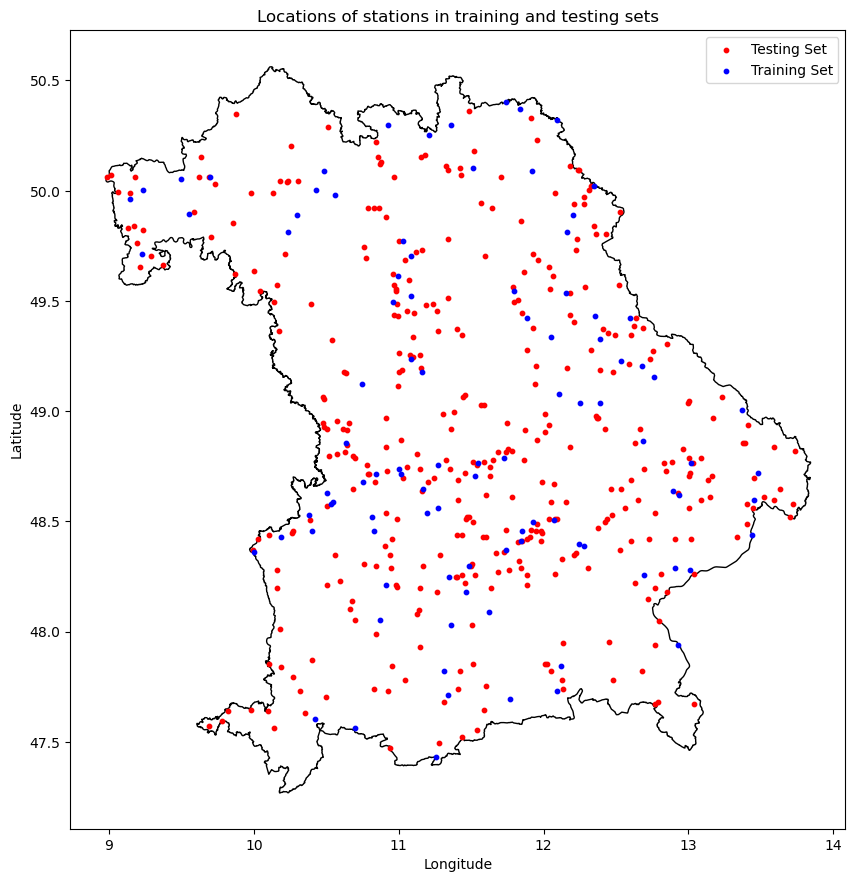

In [55]:
fig, ax = plt.subplots(figsize=(10,12))
bavaria_polygon.plot(ax = ax,color='white', edgecolor='black')
plt.scatter(sorted_df.loc[train_ind,'lon'], sorted_df.loc[train_ind,'lat'], color='red',s=10, label='Testing Set' )
plt.scatter(sorted_df.loc[test_ind,'lon'], sorted_df.loc[test_ind,'lat'], color='blue',s=10, label = 'Training Set' )
plt.title('Locations of stations in training and testing sets')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

## Default models
These are the default models without changing any parameters

In [56]:
y_train_og = sorted_df.iloc[train_ind, 0]
y_test_og = sorted_df.iloc[test_ind, 0]

In [57]:
# model :default, with spatial split, using box cox data


model_default_wss_bc = RandomForestRegressor(random_state = 42)
model_default_wss_bc.fit(X_train, y_train)
y_pred_default_wss_bc = model_default_wss_bc.predict(X_test)
rmse_model_default_wss_bc = np.sqrt(mean_squared_error(y_test_og, inv_boxcox(y_pred_default_wss_bc, lambda_boxcox)))
r2_model_default_wss_bc = r2_score(y_test, y_pred_default_wss_bc)
r_model_default_wss_bc = pearson_corr_coeff(y_test, y_pred_default_wss_bc)
print('RMSE [mg/L], model = default wss bc: ',rmse_model_default_wss_bc)
print('R2, model = default wss bc: ', r2_model_default_wss_bc)
print('R, model = default wss bc: ', r_model_default_wss_bc)

RMSE [mg/L], model = default wss bc:  1.3905898264514596
R2, model = default wss bc:  0.5035842391565024
R, model = default wss bc:  0.7114835193643168


In [58]:
# model: default, NO spatial split, using box cox data

X_nss = scaler.transform(final_df_oct_new.iloc[:, 7:])
y_nss = final_df_oct_new.iloc[:,1]
X_train_nss, X_test_nss, y_train_nss, y_test_nss = train_test_split(X_nss, y_nss, test_size=0.2, random_state=42)
train_ind_nss, test_ind_nss = train_test_split(np.arange(X_nss.shape[0]), test_size=0.2, random_state = 42)

y_test_nss_og = (final_df_oct_new.iloc[test_ind_nss, 0])
y_train_nss_og = (final_df_oct_new.iloc[train_ind_nss, 0])

model_default_nss_bc = RandomForestRegressor(random_state = 42)
model_default_nss_bc.fit(X_train_nss, y_train_nss)
y_pred_default_nss_bc = model_default_nss_bc.predict(X_test_nss)
rmse_model_default_nss_bc = np.sqrt(mean_squared_error(y_test_nss_og, inv_boxcox(y_pred_default_nss_bc, lambda_boxcox)))
r2_model_default_nss_bc = r2_score(y_test_nss, y_pred_default_nss_bc)
r_model_default_nss_bc = pearson_corr_coeff(y_test_nss, y_pred_default_nss_bc)
print('RMSE [mg/L], model = default nss bc: ',rmse_model_default_nss_bc)
print('R2, model = default nss bc: ', r2_model_default_nss_bc)
print('R, model = default nss bc: ', r_model_default_nss_bc)

RMSE [mg/L], model = default nss bc:  1.4059318336550495
R2, model = default nss bc:  0.47393829463991277
R, model = default nss bc:  0.6983584761984537


## Hyperparameter Tuning

In [59]:
# Optimization of model: with spatial split, using box cox transformed data

def objective_opt_wss_bc(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 600)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42)
    scores = cross_val_score(model_tuning, X_train, y_train, cv=5, scoring = "neg_mean_squared_error", n_jobs=32)
    rmse_scores = np.sqrt(np.abs(scores)) 
    mean_score = np.mean(rmse_scores)

    return mean_score
    
    

In [60]:
study_opt_wss_bc =  optuna.create_study(direction = "minimize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-09-10 20:35:24,058] A new study created in memory with name: no-name-05501ec6-075a-4ed9-accd-b427e944e326


In [61]:
study_opt_wss_bc.optimize(objective_opt_wss_bc, n_trials = 500, n_jobs=32)

[I 2024-09-10 20:35:46,888] Trial 11 finished with value: 0.7427510221167907 and parameters: {'n_estimators': 103, 'max_depth': 31, 'min_samples_split': 12, 'min_samples_leaf': 19}. Best is trial 11 with value: 0.7427510221167907.
[I 2024-09-10 20:35:50,111] Trial 10 finished with value: 0.7313133666970849 and parameters: {'n_estimators': 286, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.7313133666970849.
[I 2024-09-10 20:35:50,457] Trial 8 finished with value: 0.7306933168872795 and parameters: {'n_estimators': 167, 'max_depth': 39, 'min_samples_split': 14, 'min_samples_leaf': 1}. Best is trial 8 with value: 0.7306933168872795.
[I 2024-09-10 20:35:50,617] Trial 6 finished with value: 0.7520610797883419 and parameters: {'n_estimators': 149, 'max_depth': 49, 'min_samples_split': 19, 'min_samples_leaf': 22}. Best is trial 8 with value: 0.7306933168872795.
[I 2024-09-10 20:35:51,248] Trial 19 finished with value: 0.7544561790237059 and pa

[I 2024-09-10 20:35:58,891] Trial 2 finished with value: 0.729530029041497 and parameters: {'n_estimators': 600, 'max_depth': 35, 'min_samples_split': 19, 'min_samples_leaf': 11}. Best is trial 13 with value: 0.7245567624423254.
[I 2024-09-10 20:35:59,141] Trial 21 finished with value: 0.7275630122459213 and parameters: {'n_estimators': 539, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 13 with value: 0.7245567624423254.
[I 2024-09-10 20:36:00,279] Trial 39 finished with value: 0.7474981480492403 and parameters: {'n_estimators': 302, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 21}. Best is trial 13 with value: 0.7245567624423254.
[I 2024-09-10 20:36:00,311] Trial 44 finished with value: 0.7551917020456581 and parameters: {'n_estimators': 160, 'max_depth': 17, 'min_samples_split': 24, 'min_samples_leaf': 25}. Best is trial 13 with value: 0.7245567624423254.
[I 2024-09-10 20:36:00,927] Trial 30 finished with value: 0.7273956381810989 and 

[I 2024-09-10 20:36:18,580] Trial 72 finished with value: 0.7514640437187442 and parameters: {'n_estimators': 433, 'max_depth': 30, 'min_samples_split': 21, 'min_samples_leaf': 23}. Best is trial 55 with value: 0.724286362019231.
[I 2024-09-10 20:36:19,227] Trial 75 finished with value: 0.731631489498168 and parameters: {'n_estimators': 184, 'max_depth': 39, 'min_samples_split': 19, 'min_samples_leaf': 12}. Best is trial 55 with value: 0.724286362019231.
[I 2024-09-10 20:36:19,550] Trial 76 finished with value: 0.7292550490487031 and parameters: {'n_estimators': 106, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 55 with value: 0.724286362019231.
[I 2024-09-10 20:36:19,718] Trial 78 finished with value: 0.7326136892161224 and parameters: {'n_estimators': 130, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 13}. Best is trial 55 with value: 0.724286362019231.
[I 2024-09-10 20:36:20,756] Trial 62 finished with value: 0.72629055874718 and para

[I 2024-09-10 20:36:39,611] Trial 115 finished with value: 0.7938505240767364 and parameters: {'n_estimators': 2, 'max_depth': 31, 'min_samples_split': 11, 'min_samples_leaf': 13}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:36:40,111] Trial 112 finished with value: 0.7352276215609234 and parameters: {'n_estimators': 246, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 16}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:36:40,188] Trial 105 finished with value: 0.7307536957396493 and parameters: {'n_estimators': 590, 'max_depth': 27, 'min_samples_split': 27, 'min_samples_leaf': 9}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:36:40,676] Trial 113 finished with value: 0.7319908453653996 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 8}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:36:40,987] Trial 114 finished with value: 0.7343289857352

[I 2024-09-10 20:36:58,644] Trial 146 finished with value: 0.7517500879146264 and parameters: {'n_estimators': 345, 'max_depth': 16, 'min_samples_split': 28, 'min_samples_leaf': 23}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:00,037] Trial 145 finished with value: 0.743102206668137 and parameters: {'n_estimators': 471, 'max_depth': 50, 'min_samples_split': 3, 'min_samples_leaf': 20}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:00,179] Trial 152 finished with value: 0.7453644565151522 and parameters: {'n_estimators': 9, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:00,747] Trial 148 finished with value: 0.7306428171747135 and parameters: {'n_estimators': 283, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 12}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:01,695] Trial 153 finished with value: 0.732272806664

[I 2024-09-10 20:37:19,869] Trial 171 finished with value: 0.7349690147786195 and parameters: {'n_estimators': 420, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:20,510] Trial 180 finished with value: 0.7252069407426414 and parameters: {'n_estimators': 327, 'max_depth': 46, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:22,899] Trial 185 finished with value: 0.7320070894469173 and parameters: {'n_estimators': 329, 'max_depth': 42, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:22,912] Trial 187 finished with value: 0.7351791295546201 and parameters: {'n_estimators': 252, 'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 16}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:23,319] Trial 191 finished with value: 0.75143982799

[I 2024-09-10 20:37:40,589] Trial 222 finished with value: 0.7516778692454698 and parameters: {'n_estimators': 90, 'max_depth': 10, 'min_samples_split': 29, 'min_samples_leaf': 22}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:40,767] Trial 219 finished with value: 0.7415365417690475 and parameters: {'n_estimators': 230, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 19}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:40,817] Trial 218 finished with value: 0.7524014279840443 and parameters: {'n_estimators': 268, 'max_depth': 38, 'min_samples_split': 23, 'min_samples_leaf': 23}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:40,832] Trial 214 finished with value: 0.7291391376056744 and parameters: {'n_estimators': 260, 'max_depth': 28, 'min_samples_split': 21, 'min_samples_leaf': 5}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:41,214] Trial 223 finished with value: 0.7340799918

[I 2024-09-10 20:37:58,508] Trial 256 finished with value: 0.7464764160927475 and parameters: {'n_estimators': 79, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 20}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:58,672] Trial 259 finished with value: 0.7411484983421626 and parameters: {'n_estimators': 10, 'max_depth': 23, 'min_samples_split': 24, 'min_samples_leaf': 16}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:58,758] Trial 257 finished with value: 0.7347420985830045 and parameters: {'n_estimators': 33, 'max_depth': 21, 'min_samples_split': 17, 'min_samples_leaf': 6}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:59,617] Trial 254 finished with value: 0.7528550131752111 and parameters: {'n_estimators': 376, 'max_depth': 10, 'min_samples_split': 24, 'min_samples_leaf': 24}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:37:59,873] Trial 255 finished with value: 0.732652713352

[I 2024-09-10 20:38:19,704] Trial 283 finished with value: 0.7301451989996032 and parameters: {'n_estimators': 556, 'max_depth': 23, 'min_samples_split': 25, 'min_samples_leaf': 7}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:19,840] Trial 289 finished with value: 0.7375650351438527 and parameters: {'n_estimators': 409, 'max_depth': 5, 'min_samples_split': 25, 'min_samples_leaf': 18}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:20,293] Trial 288 finished with value: 0.7358508145597805 and parameters: {'n_estimators': 567, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 17}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:20,553] Trial 291 finished with value: 0.749319836182387 and parameters: {'n_estimators': 455, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 22}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:20,693] Trial 292 finished with value: 0.728423795275

[I 2024-09-10 20:38:36,967] Trial 327 finished with value: 0.7331128397760566 and parameters: {'n_estimators': 205, 'max_depth': 16, 'min_samples_split': 29, 'min_samples_leaf': 7}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:37,361] Trial 330 finished with value: 0.7341954250262349 and parameters: {'n_estimators': 58, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:37,509] Trial 329 finished with value: 0.7378300686515036 and parameters: {'n_estimators': 184, 'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 17}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:37,655] Trial 326 finished with value: 0.7497983082682247 and parameters: {'n_estimators': 487, 'max_depth': 2, 'min_samples_split': 24, 'min_samples_leaf': 16}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:37,858] Trial 333 finished with value: 0.73987758177

[I 2024-09-10 20:38:52,289] Trial 361 finished with value: 0.7307460178618601 and parameters: {'n_estimators': 202, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 12}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:52,730] Trial 354 finished with value: 0.7288273401456202 and parameters: {'n_estimators': 494, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:53,424] Trial 364 finished with value: 0.7358137640953213 and parameters: {'n_estimators': 213, 'max_depth': 34, 'min_samples_split': 22, 'min_samples_leaf': 16}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:54,025] Trial 365 finished with value: 0.7347433284015512 and parameters: {'n_estimators': 241, 'max_depth': 3, 'min_samples_split': 30, 'min_samples_leaf': 7}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:38:55,482] Trial 363 finished with value: 0.7489140816

[I 2024-09-10 20:39:14,023] Trial 398 finished with value: 0.7552339105597222 and parameters: {'n_estimators': 244, 'max_depth': 25, 'min_samples_split': 19, 'min_samples_leaf': 25}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:14,967] Trial 388 finished with value: 0.7337777724568293 and parameters: {'n_estimators': 424, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:16,022] Trial 397 finished with value: 0.7397843335835695 and parameters: {'n_estimators': 470, 'max_depth': 21, 'min_samples_split': 15, 'min_samples_leaf': 19}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:16,379] Trial 399 finished with value: 0.7350544198890191 and parameters: {'n_estimators': 402, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 16}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:16,831] Trial 394 finished with value: 0.725776428

[I 2024-09-10 20:39:32,964] Trial 432 finished with value: 0.7457347594547892 and parameters: {'n_estimators': 575, 'max_depth': 20, 'min_samples_split': 19, 'min_samples_leaf': 21}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:33,346] Trial 433 finished with value: 0.7353759938689338 and parameters: {'n_estimators': 319, 'max_depth': 15, 'min_samples_split': 25, 'min_samples_leaf': 16}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:33,961] Trial 431 finished with value: 0.7283314276718191 and parameters: {'n_estimators': 487, 'max_depth': 33, 'min_samples_split': 20, 'min_samples_leaf': 9}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:34,019] Trial 438 finished with value: 0.7314477033716946 and parameters: {'n_estimators': 137, 'max_depth': 34, 'min_samples_split': 21, 'min_samples_leaf': 7}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:34,115] Trial 442 finished with value: 0.821497096

[I 2024-09-10 20:39:53,573] Trial 465 finished with value: 0.7273147466962988 and parameters: {'n_estimators': 433, 'max_depth': 29, 'min_samples_split': 21, 'min_samples_leaf': 4}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:53,701] Trial 470 finished with value: 0.7303689676773815 and parameters: {'n_estimators': 232, 'max_depth': 35, 'min_samples_split': 21, 'min_samples_leaf': 10}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:54,376] Trial 473 finished with value: 0.7545456520778868 and parameters: {'n_estimators': 282, 'max_depth': 29, 'min_samples_split': 23, 'min_samples_leaf': 25}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:54,506] Trial 469 finished with value: 0.7282898840543154 and parameters: {'n_estimators': 282, 'max_depth': 44, 'min_samples_split': 25, 'min_samples_leaf': 3}. Best is trial 104 with value: 0.7240634047566051.
[I 2024-09-10 20:39:54,656] Trial 474 finished with value: 0.744926223

In [62]:
study_opt_wss_bc.best_params

{'n_estimators': 374,
 'max_depth': 47,
 'min_samples_split': 7,
 'min_samples_leaf': 6}

In [63]:
study_opt_wss_bc_best_params = study_opt_wss_bc.best_params

In [64]:
optuna.visualization.plot_optimization_history(study_opt_wss_bc)

In [65]:
optuna.visualization.plot_parallel_coordinate(study_opt_wss_bc)

In [66]:
optuna.visualization.plot_slice(study_opt_wss_bc, params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf' ])

In [67]:
optuna.visualization.plot_param_importances(study_opt_wss_bc)

In [68]:
# Optimization of model: NO spatial split, using box cox data

def objective_opt_nss_bc(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 600)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42)
    scores = cross_val_score(model_tuning, X_train_nss, y_train_nss, cv=5, scoring = "neg_mean_squared_error", n_jobs=32)
    rmse_scores = np.sqrt(np.abs(scores)) 
    mean_score = np.mean(rmse_scores)

    return mean_score

In [69]:
study_opt_nss_bc =  optuna.create_study(direction = "minimize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-09-10 20:40:48,814] A new study created in memory with name: no-name-c5cdd737-a963-4b86-bef6-b8b5a7ce0daf


In [70]:
study_opt_nss_bc.optimize(objective_opt_nss_bc, n_trials = 500, n_jobs=32)

[I 2024-09-10 20:40:51,979] Trial 1 finished with value: 0.745260795134803 and parameters: {'n_estimators': 331, 'max_depth': 32, 'min_samples_split': 18, 'min_samples_leaf': 23}. Best is trial 1 with value: 0.745260795134803.
[I 2024-09-10 20:40:52,671] Trial 0 finished with value: 0.7329130964155318 and parameters: {'n_estimators': 258, 'max_depth': 29, 'min_samples_split': 14, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:40:55,783] Trial 5 finished with value: 0.7432037177257296 and parameters: {'n_estimators': 128, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:40:55,810] Trial 3 finished with value: 0.7474602524901989 and parameters: {'n_estimators': 315, 'max_depth': 7, 'min_samples_split': 25, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:40:55,975] Trial 4 finished with value: 0.7437703736553058 and parameter

[I 2024-09-10 20:41:06,195] Trial 39 finished with value: 0.7351660509111981 and parameters: {'n_estimators': 162, 'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:41:07,673] Trial 37 finished with value: 0.7398098663609181 and parameters: {'n_estimators': 499, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:41:07,762] Trial 32 finished with value: 0.7373504918547096 and parameters: {'n_estimators': 572, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:41:09,922] Trial 38 finished with value: 0.7343777816355141 and parameters: {'n_estimators': 475, 'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:41:10,296] Trial 45 finished with value: 0.7438598451590794 and param

[I 2024-09-10 20:41:29,571] Trial 72 finished with value: 0.7407947303150904 and parameters: {'n_estimators': 506, 'max_depth': 39, 'min_samples_split': 30, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:41:29,731] Trial 76 finished with value: 0.7455386826093594 and parameters: {'n_estimators': 349, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:41:30,516] Trial 69 finished with value: 0.7330859989323458 and parameters: {'n_estimators': 506, 'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:41:31,476] Trial 78 finished with value: 0.7420294498007227 and parameters: {'n_estimators': 227, 'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.7329130964155318.
[I 2024-09-10 20:41:33,344] Trial 77 finished with value: 0.7391552916070181 and p

[I 2024-09-10 20:41:54,365] Trial 111 finished with value: 0.7357766061812326 and parameters: {'n_estimators': 98, 'max_depth': 38, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:41:55,443] Trial 113 finished with value: 0.7415153096193607 and parameters: {'n_estimators': 148, 'max_depth': 23, 'min_samples_split': 30, 'min_samples_leaf': 14}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:41:55,627] Trial 105 finished with value: 0.7386321622521569 and parameters: {'n_estimators': 453, 'max_depth': 32, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:41:55,662] Trial 108 finished with value: 0.7424787743597079 and parameters: {'n_estimators': 225, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:41:56,476] Trial 112 finished with value: 0.7471465240014551 and

[I 2024-09-10 20:42:11,179] Trial 146 finished with value: 0.740488417766095 and parameters: {'n_estimators': 221, 'max_depth': 46, 'min_samples_split': 22, 'min_samples_leaf': 15}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:12,002] Trial 145 finished with value: 0.7327584581888 and parameters: {'n_estimators': 265, 'max_depth': 25, 'min_samples_split': 22, 'min_samples_leaf': 8}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:12,289] Trial 136 finished with value: 0.7362796833758848 and parameters: {'n_estimators': 529, 'max_depth': 4, 'min_samples_split': 23, 'min_samples_leaf': 2}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:12,486] Trial 153 finished with value: 0.7501328113096378 and parameters: {'n_estimators': 16, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 15}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:13,102] Trial 147 finished with value: 0.7343632897028911 and par

[I 2024-09-10 20:42:28,208] Trial 186 finished with value: 0.7653637226173506 and parameters: {'n_estimators': 11, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:28,427] Trial 175 finished with value: 0.7360685466694159 and parameters: {'n_estimators': 423, 'max_depth': 47, 'min_samples_split': 24, 'min_samples_leaf': 10}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:29,379] Trial 179 finished with value: 0.7440091957733348 and parameters: {'n_estimators': 454, 'max_depth': 50, 'min_samples_split': 13, 'min_samples_leaf': 20}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:30,110] Trial 181 finished with value: 0.7450663118671416 and parameters: {'n_estimators': 534, 'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 21}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:31,535] Trial 185 finished with value: 0.7370559753362362 a

[I 2024-09-10 20:42:48,043] Trial 215 finished with value: 0.7419018362301835 and parameters: {'n_estimators': 405, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 14}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:48,945] Trial 214 finished with value: 0.7391438222251641 and parameters: {'n_estimators': 417, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 13}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:49,427] Trial 221 finished with value: 0.8165962158605543 and parameters: {'n_estimators': 336, 'max_depth': 1, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:49,504] Trial 222 finished with value: 0.8170216234684429 and parameters: {'n_estimators': 303, 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 21}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:42:49,966] Trial 217 finished with value: 0.7437496847909764 and p

[I 2024-09-10 20:43:08,735] Trial 253 finished with value: 0.7475457547635586 and parameters: {'n_estimators': 549, 'max_depth': 24, 'min_samples_split': 19, 'min_samples_leaf': 24}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:09,001] Trial 254 finished with value: 0.7375985544908171 and parameters: {'n_estimators': 336, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 12}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:09,040] Trial 259 finished with value: 0.7468780559752984 and parameters: {'n_estimators': 84, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 21}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:09,087] Trial 260 finished with value: 0.749490876382296 and parameters: {'n_estimators': 42, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 22}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:09,181] Trial 257 finished with value: 0.7405205902042129 an

[I 2024-09-10 20:43:28,848] Trial 285 finished with value: 0.7428838393409098 and parameters: {'n_estimators': 531, 'max_depth': 46, 'min_samples_split': 15, 'min_samples_leaf': 19}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:29,300] Trial 294 finished with value: 0.7433278212620957 and parameters: {'n_estimators': 88, 'max_depth': 22, 'min_samples_split': 17, 'min_samples_leaf': 19}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:30,309] Trial 286 finished with value: 0.7397086707595996 and parameters: {'n_estimators': 565, 'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 14}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:30,699] Trial 291 finished with value: 0.7409662173857252 and parameters: {'n_estimators': 368, 'max_depth': 26, 'min_samples_split': 22, 'min_samples_leaf': 16}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:32,244] Trial 297 finished with value: 0.7484347331620335

[I 2024-09-10 20:43:45,552] Trial 328 finished with value: 0.7380155184474868 and parameters: {'n_estimators': 41, 'max_depth': 43, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:45,867] Trial 322 finished with value: 0.7320512814730191 and parameters: {'n_estimators': 238, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:46,202] Trial 331 finished with value: 0.7529739597560164 and parameters: {'n_estimators': 72, 'max_depth': 19, 'min_samples_split': 27, 'min_samples_leaf': 25}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:46,939] Trial 329 finished with value: 0.7411774533434279 and parameters: {'n_estimators': 74, 'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:43:47,227] Trial 324 finished with value: 0.7503207935892037 and p

[I 2024-09-10 20:44:03,293] Trial 362 finished with value: 0.744455411291233 and parameters: {'n_estimators': 315, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 22}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:03,409] Trial 361 finished with value: 0.7402799247490839 and parameters: {'n_estimators': 166, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:03,552] Trial 359 finished with value: 0.7343254630136231 and parameters: {'n_estimators': 277, 'max_depth': 46, 'min_samples_split': 25, 'min_samples_leaf': 8}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:04,918] Trial 356 finished with value: 0.7361506138423701 and parameters: {'n_estimators': 562, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 10}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:05,466] Trial 367 finished with value: 0.7475331747098217 and p

[I 2024-09-10 20:44:24,000] Trial 388 finished with value: 0.7386642956150308 and parameters: {'n_estimators': 426, 'max_depth': 46, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:25,538] Trial 397 finished with value: 0.7374094924278605 and parameters: {'n_estimators': 225, 'max_depth': 28, 'min_samples_split': 20, 'min_samples_leaf': 1}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:26,016] Trial 401 finished with value: 0.7503989817382829 and parameters: {'n_estimators': 69, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:26,717] Trial 402 finished with value: 0.7430117208160257 and parameters: {'n_estimators': 311, 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 19}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:26,856] Trial 395 finished with value: 0.7363595723847334 and

[I 2024-09-10 20:44:46,363] Trial 434 finished with value: 0.8164805805822011 and parameters: {'n_estimators': 323, 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 16}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:46,505] Trial 427 finished with value: 0.7372791059399202 and parameters: {'n_estimators': 493, 'max_depth': 20, 'min_samples_split': 30, 'min_samples_leaf': 10}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:47,248] Trial 426 finished with value: 0.7337993938694516 and parameters: {'n_estimators': 512, 'max_depth': 33, 'min_samples_split': 21, 'min_samples_leaf': 8}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:47,752] Trial 438 finished with value: 0.7419320292555642 and parameters: {'n_estimators': 149, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 15}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:44:47,808] Trial 440 finished with value: 0.7345149867783458 an

[I 2024-09-10 20:45:03,606] Trial 473 finished with value: 0.7389158501043988 and parameters: {'n_estimators': 46, 'max_depth': 24, 'min_samples_split': 29, 'min_samples_leaf': 8}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:45:03,697] Trial 459 finished with value: 0.7366826124235104 and parameters: {'n_estimators': 535, 'max_depth': 46, 'min_samples_split': 27, 'min_samples_leaf': 3}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:45:06,048] Trial 468 finished with value: 0.7395719291168017 and parameters: {'n_estimators': 550, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 14}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:45:06,562] Trial 463 finished with value: 0.7357570889789633 and parameters: {'n_estimators': 511, 'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 2}. Best is trial 99 with value: 0.731943730898515.
[I 2024-09-10 20:45:06,823] Trial 470 finished with value: 0.7356393955044103 an

In [71]:
study_opt_nss_bc.best_params

{'n_estimators': 244,
 'max_depth': 34,
 'min_samples_split': 21,
 'min_samples_leaf': 6}

In [72]:
study_opt_nss_bc_best_params = study_opt_nss_bc.best_params

## Fitting and testing model with best parameters


In [73]:
# with spatial split, box cox data

best_n_estimators_opt_wss_bc = study_opt_wss_bc_best_params['n_estimators']
best_max_depth_opt_wss_bc = study_opt_wss_bc_best_params['max_depth']
best_min_samples_split_opt_wss_bc = study_opt_wss_bc_best_params['min_samples_split']
best_min_samples_leaf_opt_wss_bc = study_opt_wss_bc_best_params['min_samples_leaf']

best_model_opt_wss_bc = RandomForestRegressor(n_estimators = best_n_estimators_opt_wss_bc, max_depth = best_max_depth_opt_wss_bc , 
                                              min_samples_split= best_min_samples_split_opt_wss_bc, 
                                              min_samples_leaf=best_min_samples_leaf_opt_wss_bc, random_state=42)

best_model_opt_wss_bc.fit(X_train, y_train)

y_pred_opt_wss_bc = best_model_opt_wss_bc.predict(X_test)

rmse_model_opt_wss_bc = np.sqrt(mean_squared_error(y_test_og, inv_boxcox(y_pred_opt_wss_bc, lambda_boxcox)))
r2_model_opt_wss_bc = r2_score(y_test, y_pred_opt_wss_bc)
r_model_opt_wss_bc = pearson_corr_coeff(y_test, y_pred_opt_wss_bc)


print('RMSE [mg/L], model = opt wss bc: ',rmse_model_opt_wss_bc)
print('R2, model = opt wss bc: ', r2_model_opt_wss_bc)
print('R, model = opt wss bc: ', r_model_opt_wss_bc)

RMSE [mg/L], model = opt wss bc:  1.3779790957973184
R2, model = opt wss bc:  0.5166013584047315
R, model = opt wss bc:  0.719562222452245


In [74]:
# NO spatial split, box cox data

best_n_estimators_opt_nss_bc = study_opt_nss_bc_best_params['n_estimators']
best_max_depth_opt_nss_bc = study_opt_nss_bc_best_params['max_depth']
best_min_samples_split_opt_nss_bc = study_opt_nss_bc_best_params['min_samples_split']
best_min_samples_leaf_opt_nss_bc = study_opt_nss_bc_best_params['min_samples_leaf']

best_model_opt_nss_bc = RandomForestRegressor(n_estimators = best_n_estimators_opt_nss_bc, max_depth = best_max_depth_opt_nss_bc , 
                                              min_samples_split= best_min_samples_split_opt_nss_bc, 
                                              min_samples_leaf=best_min_samples_leaf_opt_nss_bc, random_state=42)

best_model_opt_nss_bc.fit(X_train_nss, y_train_nss)

y_pred_opt_nss_bc = best_model_opt_nss_bc.predict(X_test_nss)

rmse_model_opt_nss_bc = np.sqrt(mean_squared_error(y_test_nss_og, inv_boxcox(y_pred_opt_nss_bc, lambda_boxcox)))
r2_model_opt_nss_bc = r2_score(y_test_nss, y_pred_opt_nss_bc)
r_model_opt_nss_bc = pearson_corr_coeff(y_test_nss, y_pred_opt_nss_bc)

print('RMSE [mg/L], model = opt nss bc: ',rmse_model_opt_nss_bc)
print('R2, model = opt nss bc: ', r2_model_opt_nss_bc)
print('R, model = opt nss bc: ', r_model_opt_nss_bc)

RMSE [mg/L], model = opt nss bc:  1.3534534923213244
R2, model = opt nss bc:  0.5079963598199624
R, model = opt nss bc:  0.723626482005928


## Feature Importance

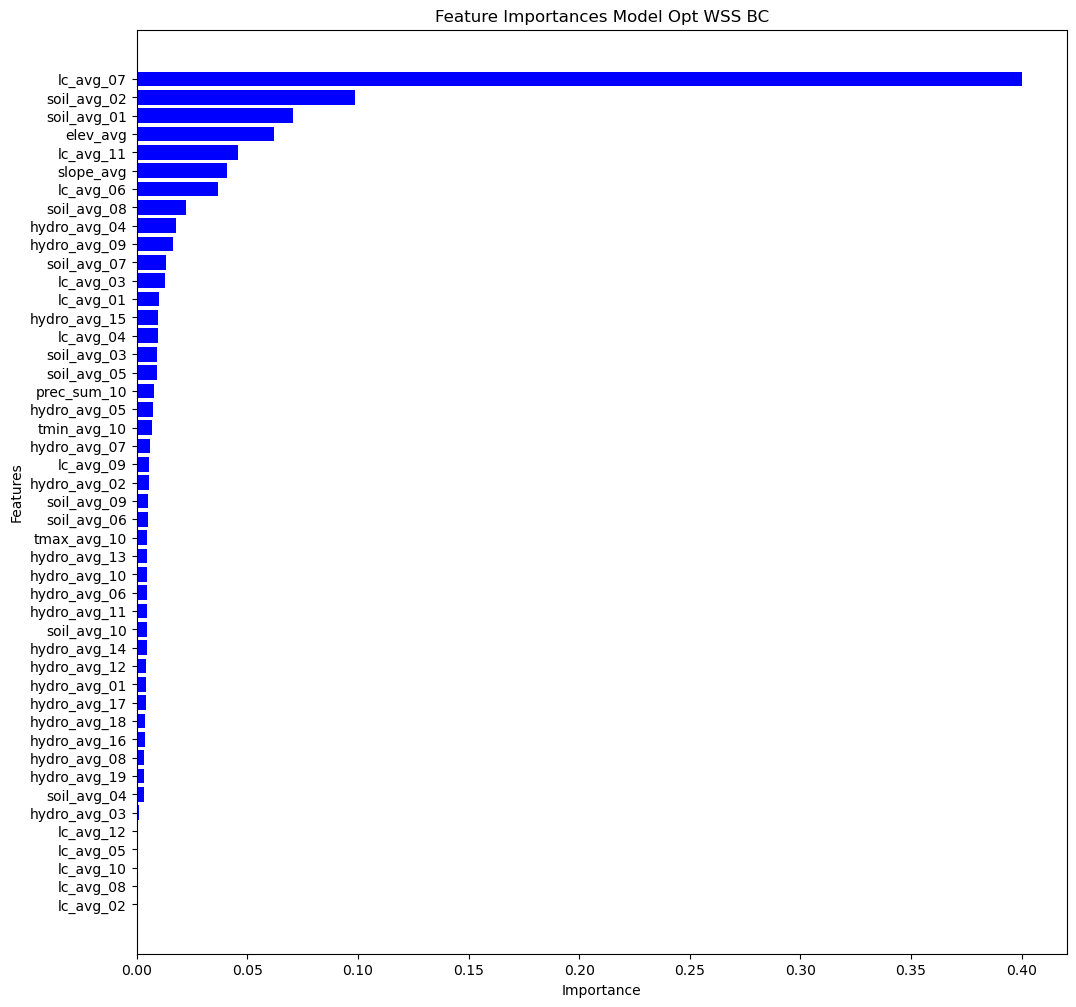

In [75]:
feature_importances_opt_wss_bc = best_model_opt_wss_bc.feature_importances_

indices = np.argsort(feature_importances_opt_wss_bc)

# Prepare the figure
plt.figure(figsize=(12, 12))
plt.title('Feature Importances Model Opt WSS BC')

# Create horizontal bars
plt.barh(range(len(indices)), feature_importances_opt_wss_bc[indices], color='b', align='center')

# Add feature names as y-tick labels
plt.yticks(range(len(indices)), [final_df_oct_new.columns[7:][i] for i in indices])

# Label the axes
plt.xlabel('Importance')
plt.ylabel('Features')

# Show the plot
plt.show()

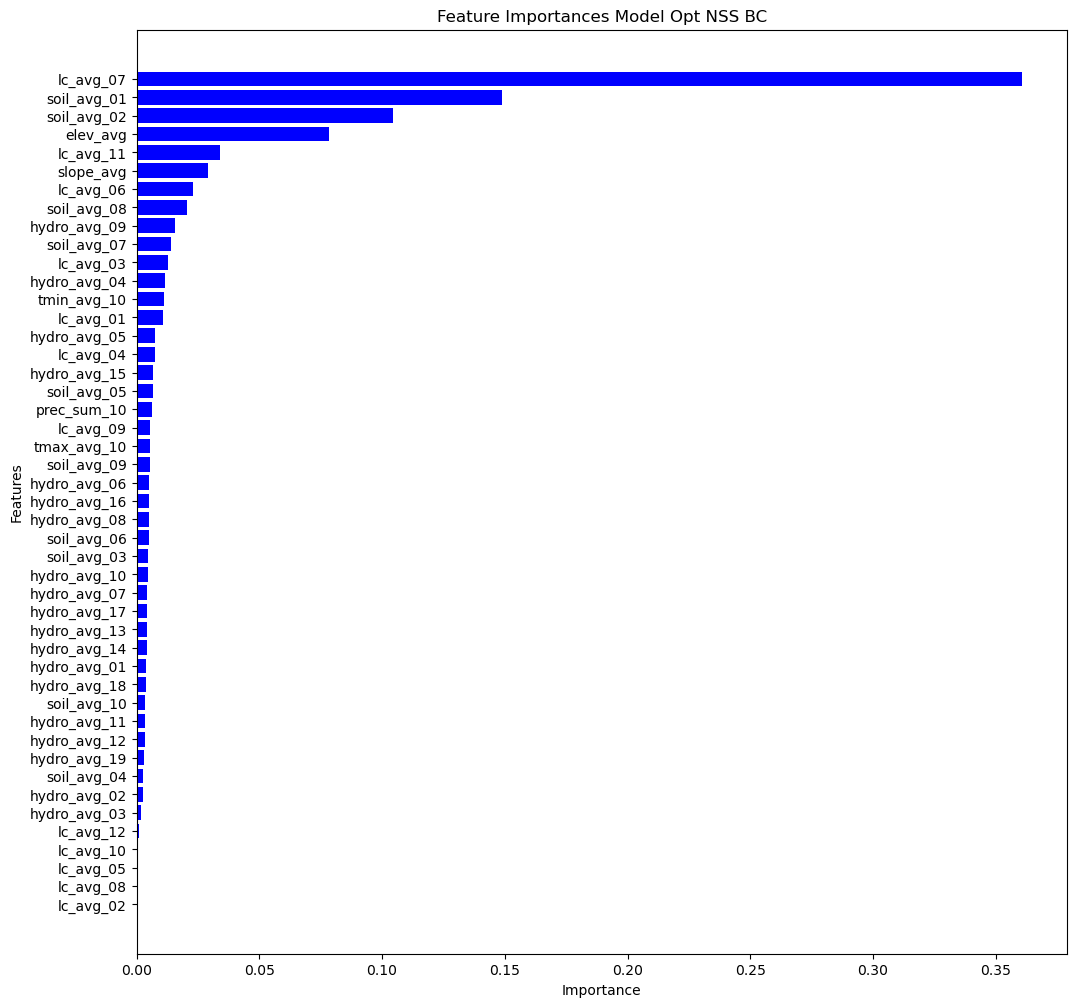

In [76]:
feature_importances_opt_nss_bc = best_model_opt_nss_bc.feature_importances_

indices = np.argsort(feature_importances_opt_nss_bc)

# Prepare the figure
plt.figure(figsize=(12, 12))
plt.title('Feature Importances Model Opt NSS BC')

# Create horizontal bars
plt.barh(range(len(indices)), feature_importances_opt_nss_bc[indices], color='b', align='center')

# Add feature names as y-tick labels
plt.yticks(range(len(indices)), [final_df_oct_new.columns[7:][i] for i in indices])

# Label the axes
plt.xlabel('Importance')
plt.ylabel('Features')

# Show the plot
plt.show()

In [77]:
np.sum(np.sort(feature_importances_opt_wss_bc*100))

100.0

In [78]:
np.sort(feature_importances_opt_nss_bc*100)

array([0.00000000e+00, 0.00000000e+00, 7.34916130e-03, 2.19096327e-02,
       7.95465928e-02, 1.77102408e-01, 2.44816571e-01, 2.55756574e-01,
       2.82634808e-01, 3.25516605e-01, 3.40064061e-01, 3.43380495e-01,
       3.77983268e-01, 3.78277482e-01, 4.07059454e-01, 4.08510462e-01,
       4.20735471e-01, 4.36265968e-01, 4.58435058e-01, 4.65038328e-01,
       4.85605527e-01, 4.89786216e-01, 4.92424993e-01, 5.20827383e-01,
       5.26783178e-01, 5.32934913e-01, 5.48686683e-01, 6.37594950e-01,
       6.68836071e-01, 6.82603746e-01, 7.34227918e-01, 7.57366552e-01,
       1.07301009e+00, 1.11434248e+00, 1.13548361e+00, 1.28187133e+00,
       1.41370270e+00, 1.54758504e+00, 2.06680405e+00, 2.28941337e+00,
       2.91089472e+00, 3.40152283e+00, 7.84791846e+00, 1.04499764e+01,
       1.48728315e+01, 3.60865829e+01])

In [79]:
features_filtered = [final_df_oct_new.iloc[:,7:].columns[i] for i in range(len(feature_importances_opt_wss_bc)) if feature_importances_opt_wss_bc[i] > 0.01 ]

In [80]:
features_filtered_nss = [final_df_oct_new.iloc[:,7:].columns[i] for i in range(len(feature_importances_opt_nss_bc)) if feature_importances_opt_nss_bc[i] > 0.01 ]
print(features_filtered_nss)

['slope_avg', 'elev_avg', 'lc_avg_01', 'lc_avg_03', 'lc_avg_06', 'lc_avg_07', 'lc_avg_11', 'hydro_avg_04', 'hydro_avg_09', 'soil_avg_01', 'soil_avg_02', 'soil_avg_07', 'soil_avg_08', 'tmin_avg_10']


In [81]:
# Save required information to disk
month = '_oct'

variables2save = [X_train, X_test, y_train, y_test, y_train_og, y_test_og,
                  train_ind, test_ind, sorted_df,
                  rmse_model_default_wss_bc, r2_model_default_wss_bc, r_model_default_wss_bc,
                  y_pred_default_wss_bc,
                  rmse_model_opt_wss_bc, r2_model_opt_wss_bc, r_model_opt_wss_bc,
                  study_opt_wss_bc,
                  study_opt_wss_bc_best_params,
                  feature_importances_opt_wss_bc,
                  y_pred_opt_wss_bc,
                 X_train_nss, X_test_nss, y_train_nss, y_test_nss,y_train_nss_og, y_test_nss_og,
                  train_ind_nss, test_ind_nss,
                 rmse_model_default_nss_bc, r2_model_default_nss_bc, r_model_default_nss_bc,
                  y_pred_default_nss_bc,
                  rmse_model_opt_nss_bc, r2_model_opt_nss_bc, r_model_opt_nss_bc,
                  study_opt_nss_bc,
                  study_opt_nss_bc_best_params,
                  feature_importances_opt_nss_bc,
                  y_pred_opt_nss_bc]

variables_name = ['X_train', 'X_test', 'y_train', 'y_test', 'y_train_og', 'y_test_og',
                  'train_ind_wss', 'test_ind_wss', 'sorted_df',
                  'rmse_model_default_wss_bc', 'r2_model_default_wss_bc', 'r_model_default_wss_bc',
                  'y_pred_default_wss_bc',
                  'rmse_model_opt_wss_bc', 'r2_model_opt_wss_bc', 'r_model_opt_wss_bc',
                  'study_opt_wss_bc',
                  'study_opt_wss_bc_best_params', 
                  'feature_importances_opt_wss_bc',
                  'y_pred_opt_wss_bc',
                 'X_train_nss', 'X_test_nss', 'y_train_nss', 'y_test_nss','y_train_nss_og', 'y_test_nss_og',
                  'train_ind_nss', 'test_ind_nss',
                 'rmse_model_default_nss_bc', 'r2_model_default_nss_bc', 'r_model_default_nss_bc',
                  'y_pred_default_nss_bc',
                  'rmse_model_opt_nss_bc', 'r2_model_opt_nss_bc', 'r_model_opt_nss_bc',
                  'study_opt_nss_bc',
                  'study_opt_nss_bc_best_params', 
                  'feature_importances_opt_nss_bc',
                  'y_pred_opt_nss_bc']

variables_save_name = [i+month for i in variables_name]

for i in range(len(variables2save)):
    # save the variables
    filepath = variables_save_name[i]
    with open(filepath, 'wb') as file:
        pickle.dump(variables2save[i], file)